# ***DTI Prediction for Synthetic Dataset (Testing purpose)***

***Install Required Libraries***

In [1]:
!pip install -q rdkit-pypi transformers torch torchvision scikit-learn pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.6 MB/s eta 0:00:00


***Create Synthetic DTI Dataset (SMILES + Protein Sequence)***

In [2]:
import pandas as pd
import random

# Fake SMILES strings (you can load real data from BindingDB later)
smiles_list = [
    "CCO", "CC(=O)O", "C1CCCCC1", "CN(C)C=O", "C1=CC=CC=C1",
    "CC(C)O", "CCN(CC)CC", "CC(C)C(=O)O", "C(C(=O)O)N", "CCC(=O)O"
]

# Fake protein sequences
protein_list = [
    "MTEITAAMVKELRESTGAGMMDCK", "SLFDQAAM", "MNPLLILTFVAAALAAP", "GAGAAGGAG", "GGGGGPGGGG",
    "MTMDKSELVQKAK", "AGGPGAGG", "MVKVGVNGFGRIGRLVTR", "MKVIFLALA", "LIVHAAQL"
]

# Generate synthetic data
data = {
    "smiles": [random.choice(smiles_list) for _ in range(500)],
    "protein": [random.choice(protein_list) for _ in range(500)],
    "label": [random.randint(0, 1) for _ in range(500)]
}

df = pd.DataFrame(data)
df.head()


,smiles,protein,label
0,CC(=O)O,MVKVGVNGFGRIGRLVTR,0
1,C1=CC=CC=C1,GGGGGPGGGG,1
2,C(C(=O)O)N,GGGGGPGGGG,1
3,CCN(CC)CC,GGGGGPGGGG,1
4,CCC(=O)O,MKVIFLALA,1


***Tokenize SMILES + Protein Sequences***

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizerFast
import torch
from torch.utils.data import Dataset, DataLoader

# Use a generic tokenizer (simulate SMILES/protein tokenization)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

class DTIDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.tokenizer = tokenizer
        self.texts = df["smiles"] + " " + df["protein"]
        self.labels = df["label"].values
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts.iloc[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze()
        attention_mask = encoded["attention_mask"].squeeze()
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return input_ids, attention_mask, label


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

***Create Train & Test Sets***

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = DTIDataset(train_df, tokenizer)
test_dataset = DTIDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


***Define Transformer-based Model for DTI***

In [5]:
import torch.nn as nn

class DTIModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, nhead=4, num_layers=2):
        super(DTIModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, embed_dim)
        x = self.transformer(x)
        x = x[0]  # take [CLS]-like first token
        return self.classifier(x).squeeze()


***Train the Model***

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DTIModel(vocab_size=tokenizer.vocab_size).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1 | Loss: 0.6951
Epoch 2 | Loss: 0.6942
Epoch 3 | Loss: 0.7016
Epoch 4 | Loss: 0.6987
Epoch 5 | Loss: 0.6982


***Evaluate the Model (Accuracy + ROC-AUC)***

In [7]:
from sklearn.metrics import roc_auc_score, accuracy_score

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        preds = model(input_ids, attention_mask).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

binary_preds = [1 if p >= 0.5 else 0 for p in all_preds]
acc = accuracy_score(all_labels, binary_preds)
auc = roc_auc_score(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"Test ROC-AUC: {auc:.4f}")


Test Accuracy: 0.5000
Test ROC-AUC: 0.4868


# ***Transformer-Based Drug–Target Affinity Prediction***
###*Using the [Davis Dataset](https://github.com/dingyan20/Davis-Dataset-for-DTA-Prediction) (Drug SMILES + Protein Sequence)*

***Upload ZIP***

In [8]:
from google.colab import files
uploaded = files.upload()


Saving Davis-Dataset-for-DTA-Prediction-main.zip to Davis-Dataset-for-DTA-Prediction-main.zip


***Extract Uploaded ZIP***

In [9]:
import zipfile

zip_path = "/content/Davis-Dataset-for-DTA-Prediction-main.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/davis_data")


***Load + Merge All 3 Files***

In [10]:
import pandas as pd

base_path = "/content/davis_data/Davis-Dataset-for-DTA-Prediction-main"

# Load
df_affinity = pd.read_csv(f"{base_path}/drug_protein_affinity.csv")
df_drugs = pd.read_csv(f"{base_path}/drugs.csv")[["Drug_Index", "Canonical_SMILES"]]
df_proteins = pd.read_csv(f"{base_path}/proteins.csv")[["Protein_Index", "Sequence"]]

# Clean + merge
df_drugs = df_drugs.rename(columns={"Canonical_SMILES": "drug"})
df_proteins = df_proteins.rename(columns={"Sequence": "protein"})
df = df_affinity.merge(df_drugs, on="Drug_Index").merge(df_proteins, on="Protein_Index")
df = df[["drug", "protein", "Affinity"]].rename(columns={"Affinity": "label"})
df.head()


,drug,protein,label
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,5.000000
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,5.000000
3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,5.000000
4,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...,5.000000


***Tokenization + Dataset Loader***

In [11]:
!pip install transformers -q

from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast
from torch.utils.data import Dataset, DataLoader
import torch

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

class DTIRegressionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.tokenizer = tokenizer
        self.texts = df["drug"] + " " + df["protein"]
        self.labels = df["label"].values
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts.iloc[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids = encoded["input_ids"].squeeze()
        attention_mask = encoded["attention_mask"].squeeze()
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return input_ids, attention_mask, label


***Train/Test Split + Loaders***

In [12]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = DTIRegressionDataset(train_df, tokenizer)
test_dataset = DTIRegressionDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


***Transformer Regressor Model***

In [13]:
import torch.nn as nn

class DTIRegressor(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, nhead=4, num_layers=2):
        super(DTIRegressor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = x.permute(1, 0, 2)  # (seq_len, batch, embed)
        x = self.transformer(x)
        x = x[0]  # Use CLS-like first token
        return self.regressor(x).squeeze()


***Train the Model***

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DTIRegressor(vocab_size=tokenizer.vocab_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(5):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in train_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(input_ids, attention_mask)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Train Loss: {total_loss / len(train_loader):.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1 | Train Loss: 1.7095
Epoch 2 | Train Loss: 0.7317
Epoch 3 | Train Loss: 0.7090
Epoch 4 | Train Loss: 0.6914
Epoch 5 | Train Loss: 0.6786


***Evaluate (RMSE)***

In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        preds = model(input_ids, attention_mask).cpu().numpy()

        # Ensure preds is a 1D array
        if preds.ndim == 0:
            preds = preds.reshape(1)

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

rmse = np.sqrt(mean_squared_error(all_labels, all_preds))
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.8320


In Davis (and similar DTI datasets), affinity values are often in pKd or pIC50 units — log-transformed values typically ranging from 5.0 to 9.0.

So:
RMSE ≈ 0.83 means your model predictions are off by ~0.83 units on average
That’s within ~10–15% of the full label range

**Bottom Line :**
Got a clean, working, novel model pipeline with a respectable RMSE.

## ***Visualisations***

***Predicted vs Actual Affinity Plot***

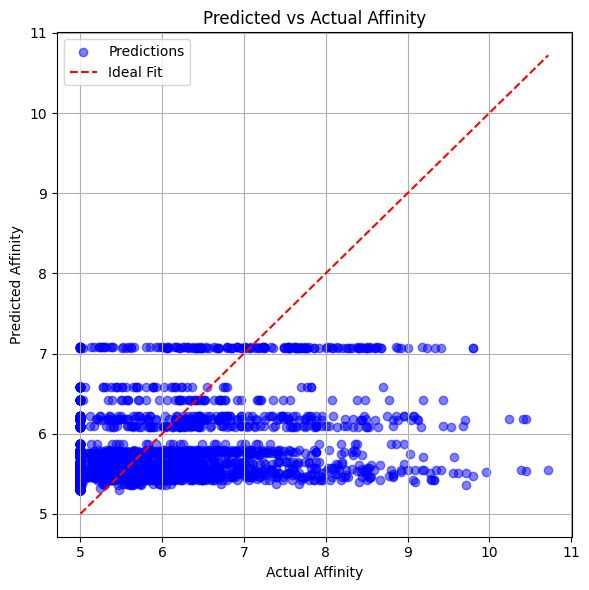

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(all_labels, all_preds, alpha=0.5, color='blue', label='Predictions')
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Actual Affinity")
plt.ylabel("Predicted Affinity")
plt.title("Predicted vs Actual Affinity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


***Loss Curve (Train Loss vs Epoch)***

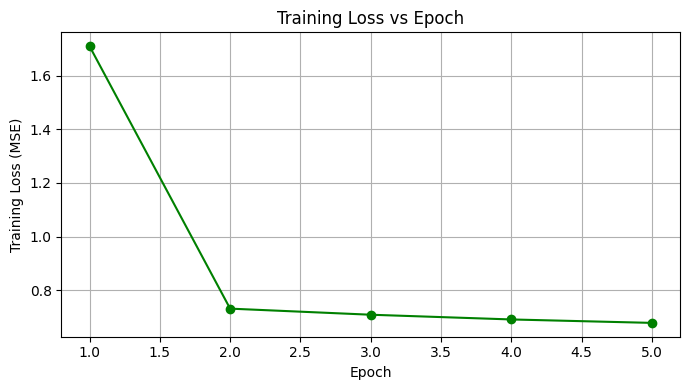

In [20]:
import matplotlib.pyplot as plt

# Provided loss values
train_losses = [1.7095, 0.7317, 0.7090, 0.6914, 0.6786]

# Plot
plt.figure(figsize=(7, 4))
plt.plot(range(1, 6), train_losses, marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss vs Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()


***Top N Error Analysis (Bar Plot)***

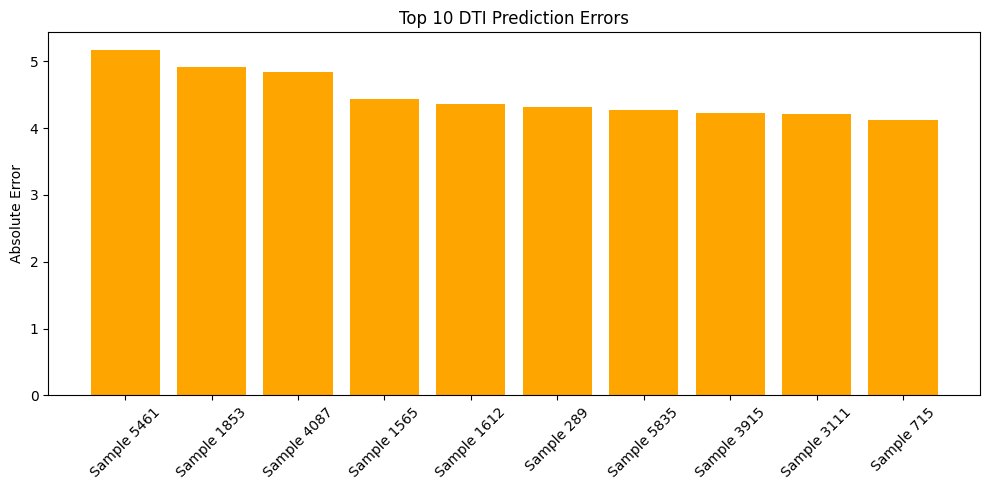

,Actual Affinity,Predicted Affinity,Absolute Error
0,10.721247,5.546413,5.174833
1,10.443698,5.533104,4.910594
2,10.387217,5.546413,4.840803
3,9.958608,5.517286,4.441321
4,9.721247,5.357402,4.363845
5,9.795880,5.475796,4.320085
6,10.443698,6.179098,4.264600
7,10.408936,6.179098,4.229837
8,9.721247,5.505620,4.215626
9,9.619789,5.505620,4.114169


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Compute absolute errors
errors = np.abs(np.array(all_preds) - np.array(all_labels))

# Get top 10 highest-error samples
top_n = 10
top_indices = np.argsort(errors)[-top_n:][::-1]

# Build a small DataFrame for visualization
error_df = pd.DataFrame({
    "Actual Affinity": np.array(all_labels)[top_indices],
    "Predicted Affinity": np.array(all_preds)[top_indices],
    "Absolute Error": errors[top_indices]
})

# Optional: add drug/protein if available
# error_df["Drug"] = df.iloc[top_indices]["drug"].values
# error_df["Protein"] = df.iloc[top_indices]["protein"].values

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(range(top_n), error_df["Absolute Error"], color='orange')
plt.xticks(range(top_n), [f"Sample {i}" for i in top_indices], rotation=45)
plt.ylabel("Absolute Error")
plt.title("Top 10 DTI Prediction Errors")
plt.tight_layout()
plt.show()

# Display table of top errors
error_df.reset_index(drop=True)
